In [41]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

import ot

import jax
import jax.numpy as jnp

from src import sinkhorn
from dataset_generators import empirical_distributions

In [50]:
plt.rc('font', family = 'serif')

### Experiments on 1d data
---
We are generating the data on the real line $\mathbb{R}$ from the normal distribution. 

In [13]:
n_samples = 20

x_i = generate_1d_normal(n_samples)
x_f = generate_1d_normal(n_samples)

C = cdist(x_i, x_f)
C = jnp.asarray(C)

a = jnp.ones(n_samples) / n_samples
b = jnp.ones(n_samples) / n_samples

Let us have a look at the effect of regularization on the optimal assignment

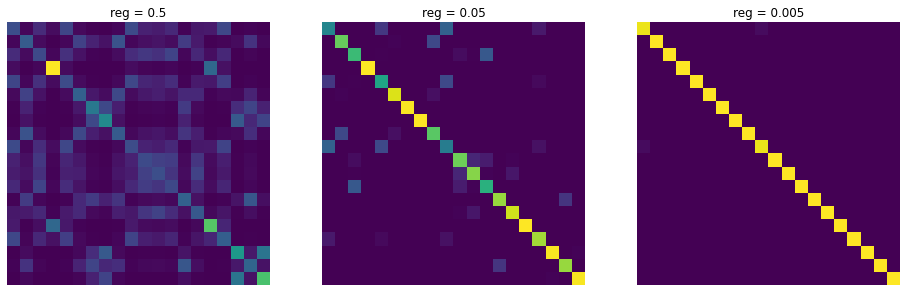

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))

for idx, reg in enumerate([5e-1, 5e-2, 5e-3]):
    G = sinkhorn.sinkhorn_knopp(C, reg = reg, a = a, b = b)
    ax[idx].imshow(G)
    ax[idx].axis('off')
    
    ax[idx].set_title(f'reg = {reg}')
    
plt.savefig("results/1d_with_different_regularization.png")

Generate a larger dataset

In [27]:
n_samples = 1024

x_i = empirical_distributions.generate_1d_normal_numpy(n_samples)
x_f = empirical_distributions.generate_1d_normal_numpy(n_samples)

C = cdist(x_i, x_f)
C /= C.max()

a = np.ones(n_samples) / n_samples
b = np.ones(n_samples) / n_samples

Let us measure the dependence of the time elapsed on the regularization parameter

In [38]:
regs = np.logspace(-10, 0, num = 20, base = 2)

tm1, tm1_err = [], []

for reg in regs:
    t = %timeit -o sinkhorn.sinkhorn_knopp(C, reg = reg, a = a, b = b)
    tm1.append(t.average)
    tm1_err.append(t.stdev)

1.42 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.85 s ± 730 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.21 s ± 89.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.04 s ± 548 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.82 s ± 244 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.4 s ± 237 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.6 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.31 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
688 ms ± 35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
364 ms ± 41.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
205 ms ± 31.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
142 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
91.9 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
98.9 ms ± 8.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
83.4 ms ± 6.25 ms per loop (mean ± std. dev. of 7 r

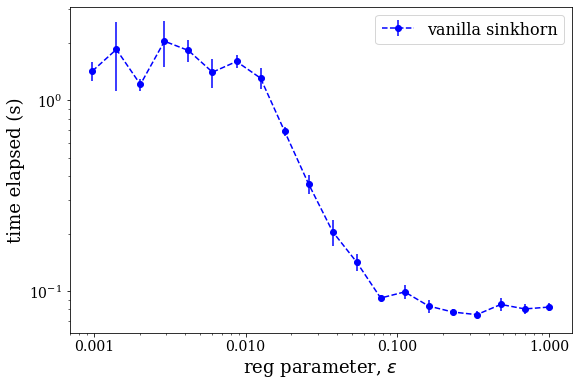

In [52]:
plt.figure(figsize = (9, 6))

plt.errorbar(regs, tm1, yerr = tm1_err, fmt = 'bo--', label = 'vanilla sinkhorn')

plt.xscale("log")
plt.yscale("log")

plt.yticks(fontsize = 14)
plt.xticks([1e-3, 1e-2, 1e-1, 1e0], fontsize = 14)
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlabel(r"reg parameter, $\varepsilon$", fontsize = 18)
plt.ylabel("time elapsed (s)", fontsize = 18)

plt.legend(fontsize = 16)

In [55]:
ns = 2 ** np.arange(5, 12)

tm1, tm1_err = [], []

for n_samples in ns:
    x_i = empirical_distributions.generate_1d_normal_numpy(n_samples)
    x_f = empirical_distributions.generate_1d_normal_numpy(n_samples)

    C = cdist(x_i, x_f)
    C /= C.max()

    a = np.ones(n_samples) / n_samples
    b = np.ones(n_samples) / n_samples
    
    t = %timeit -o sinkhorn.sinkhorn_knopp(C, reg = 1e-2, a = a, b = b)
    tm1.append(t.average)
    tm1_err.append(t.stdev)

15.7 ms ± 289 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.27 ms ± 20 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
112 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
152 ms ± 8.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
233 ms ± 64.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
891 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.31 s ± 333 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


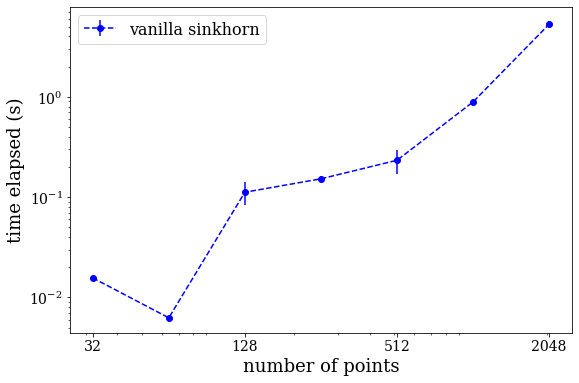

In [71]:
plt.figure(figsize = (9, 6))

plt.errorbar(ns, tm1, yerr = tm1_err, fmt = 'bo--', label = 'vanilla sinkhorn')

plt.xscale("log")
plt.yscale("log")

plt.yticks(fontsize = 14)
plt.xticks([32, 128, 512, 2048], fontsize = 14)
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlabel(r"number of points", fontsize = 18)
plt.ylabel("time elapsed (s)", fontsize = 18)

plt.legend(fontsize = 16)

### Measuring performance on stabilized version
---

In [73]:
n_samples = 256

x_i = empirical_distributions.generate_1d_normal_numpy(n_samples)
x_f = empirical_distributions.generate_1d_normal_numpy(n_samples)

C = cdist(x_i, x_f)
C /= C.max()

a = np.ones(n_samples) / n_samples
b = np.ones(n_samples) / n_samples

In [74]:
regs = np.logspace(-10, 0, num = 20, base = 2)

tm1, tm1_err = [], []

for reg in regs:
    t = %timeit -o sinkhorn.sinkhorn_stabilized(C, reg = reg, a = a, b = b)
    tm1.append(t.average)
    tm1_err.append(t.stdev)

603 ms ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
799 ms ± 241 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
971 ms ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
807 ms ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
719 ms ± 51.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
672 ms ± 52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
676 ms ± 90.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
583 ms ± 63.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
404 ms ± 54.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
245 ms ± 94.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
91.7 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
58.1 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.9 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.1 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.9 ms ± 2.8 ms per loop (mean ± std. de

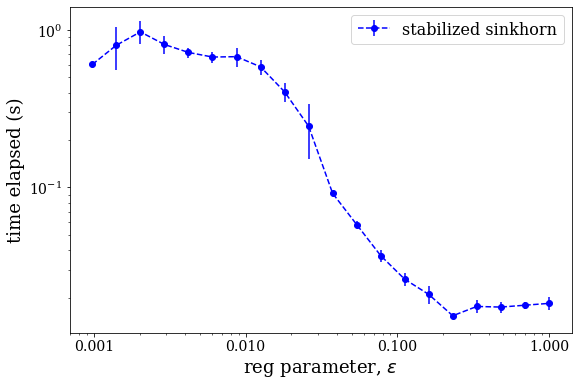

In [75]:
plt.figure(figsize = (9, 6))

plt.errorbar(regs, tm1, yerr = tm1_err, fmt = 'bo--', label = 'stabilized sinkhorn')

plt.xscale("log")
plt.yscale("log")

plt.yticks(fontsize = 14)
plt.xticks([1e-3, 1e-2, 1e-1, 1e0], fontsize = 14)
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlabel(r"reg parameter, $\varepsilon$", fontsize = 18)
plt.ylabel("time elapsed (s)", fontsize = 18)

plt.legend(fontsize = 16)

Measure the dependence of estimated time on the size of the data

In [76]:
ns = 2 ** np.arange(3, 10)

tm1, tm1_err = [], []

for n_samples in ns:
    x_i = empirical_distributions.generate_1d_normal_numpy(n_samples)
    x_f = empirical_distributions.generate_1d_normal_numpy(n_samples)

    C = cdist(x_i, x_f)
    C /= C.max()

    a = np.ones(n_samples) / n_samples
    b = np.ones(n_samples) / n_samples
    
    t = %timeit -o sinkhorn.sinkhorn_knopp(C, reg = 1e-2, a = a, b = b)
    tm1.append(t.average)
    tm1_err.append(t.stdev)

2.15 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.7 ms ± 468 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.1 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.72 ms ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
118 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
169 ms ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
249 ms ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


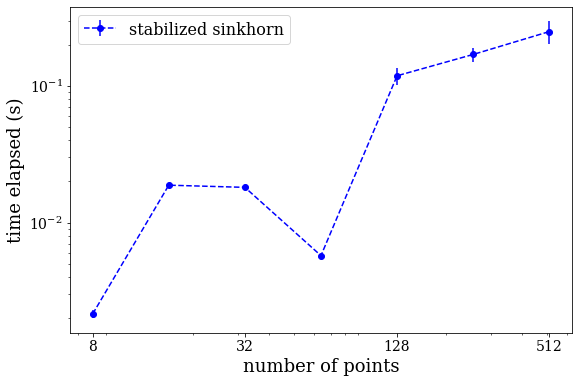

In [79]:
plt.figure(figsize = (9, 6))

plt.errorbar(ns, tm1, yerr = tm1_err, fmt = 'bo--', label = 'stabilized sinkhorn')

plt.xscale("log")
plt.yscale("log")

plt.yticks(fontsize = 14)
plt.xticks([8, 32, 128, 512], fontsize = 14)
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlabel(r"number of points", fontsize = 18)
plt.ylabel("time elapsed (s)", fontsize = 18)

plt.legend(fontsize = 16)